In [1]:
import pandas as pd
import numpy as np

In [2]:
from stridze.db import engine

In [3]:
df = pd.read_sql_table('activities', engine)

In [4]:
laps = pd.read_sql_table('laps', con=engine, index_col='id')

<Axes: xlabel='start_time'>

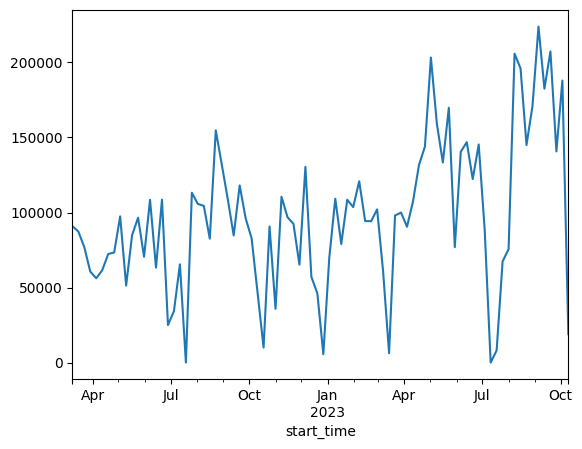

In [5]:
m = pd.merge(df, laps.groupby('activity_id').first().reset_index(), left_on='id', right_on='activity_id', how='outer')
m.set_index('start_time', inplace=True)
m.index = pd.to_datetime(m.index)
m.distance.groupby(pd.Grouper(freq='D')).sum().groupby(pd.Grouper(freq='7D')).sum().iloc[-12*7:].plot()

In [6]:
records = pd.read_sql_table('records', con=engine, index_col='id')

In [7]:
records['enhanced_speed'] *= 3.6

(0.0, 25.0)

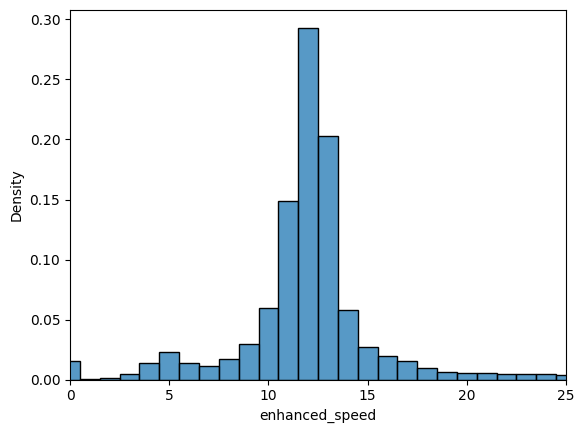

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=records, x="enhanced_speed", discrete=True, binwidth=1, binrange=(0, 25), stat='density')
plt.xlim(0, 25)

<Axes: xlabel='enhanced_speed', ylabel='Density'>

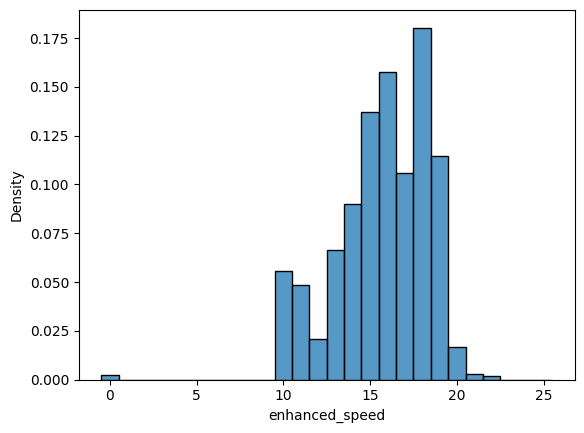

In [9]:
activity = records.loc[records['activity_id'] == 12089671097]
sns.histplot(data=activity, x="enhanced_speed", discrete=True, binwidth=1, binrange=(0, 25), stat='density')


In [10]:
activity['distance'] = activity.distance.diff() / 1000

/var/folders/8h/p7tllcw96sv_k_1rvz_4h51m0000gn/T/ipykernel_6816/4223523242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity['distance'] = activity.distance.diff() / 1000


(17.0, 44.0)

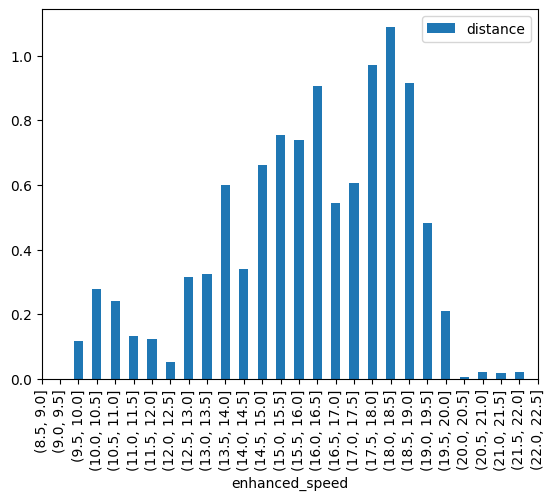

In [11]:
# bins = pd.cut(records['enhanced_speed'], range(25))
bins = pd.cut(records['enhanced_speed'], bins=np.arange(0, 25.5, 0.5))

grouped = activity.groupby(bins)['distance'].sum().reset_index()
# grouped['enhanced_speed'] = pd.IntervalIndex(grouped['enhanced_speed']).mid
grouped.plot.bar(x='enhanced_speed', y='distance')
plt.xlim(17, 44)

In [12]:
from stridze.vdot import user_VDOT

df = pd.read_sql_table('activities', con=engine, index_col='id')
df['vdot'] = df.apply(lambda row: user_VDOT(row['distance'] / 1.005, 'meters', row['elapsed_time'] / 60.), axis=1)

In [13]:
df[['vdot']].sort_values(by='vdot', ascending=False).head(10)

,vdot
id,
11772574973,108.436097
12228509616,107.921844
11458334063,107.602373
12214866013,104.637947
12027587146,104.276706
11887215773,103.705204
11997019958,102.769315
11000906113,102.347782
11750625011,101.261279


In [22]:
from stridze.vdot import percent_vo2max_to_percent_hrr, percent_hrr_to_percent_vo2max

FCM = 192 - 0.007 * 28 ** 2
FCR = 42

In [23]:
def get_hrr_from_activity_time(time):
    time_perc = 1.1574074074074075e-05 * time
    return -70.631 * time_perc + 91.86

def get_adjusted_vdot(vdot, time, actual_hrr):
    target_hrr = get_hrr_from_activity_time(time)
    if actual_hrr < target_hrr:
        return vdot * (target_hrr / actual_hrr)
    return vdot

In [29]:
df['hr_adjusted_vdot'] = df.apply(lambda row: row['vdot'] * 100 / percent_vo2max_to_percent_hrr((row['average_heart_rate'] - FCR) / (FCM - FCR) * 100) , axis=1)
df['adjusted_vdot'] = df.apply(lambda row: get_adjusted_vdot(row['vdot'], row['elapsed_time'], (row['average_heart_rate'] - FCR) / (FCM - FCR) * 100), axis=1)

In [30]:
df[['vdot', 'hr_adjusted_vdot', 'adjusted_vdot', 'average_heart_rate']].sort_values(by='id', ascending=False).head(10)

,vdot,hr_adjusted_vdot,adjusted_vdot,average_heart_rate
id,,,,
12260855787,34.060510,56.393281,52.615984,127.0
12260855622,47.074904,61.470617,55.840618,152.0
12260855418,38.383342,62.216882,57.344896,129.0
12243646764,39.698310,65.727670,59.436519,127.0
12228509616,107.921844,169.595726,152.301265,132.0
12225793291,35.305522,56.051680,52.330337,131.0
12225788724,52.099256,65.806464,59.364314,156.0
12225784477,32.364317,56.619008,53.467448,122.0
12225782898,37.840040,60.075526,55.000097,131.0


In [20]:
from datetime import datetime
today = datetime.today()
today - datetime(2023, 1, 1)

datetime.timedelta(days=283, seconds=31661, microseconds=310560)

In [21]:
df.head()

,user_id,elapsed_time,moving_time,distance,elevation_gain,elevation_loss,average_pace,average_moving_pace,average_cadence,average_heart_rate,max_heart_rate,average_stride_length,average_temperature,calories,vdot,hr_adjusted_vdot,adjusted_vdot
id,,,,,,,,,,,,,,,,,
11890249779,1,2639,2633.0,8420,32.0,33.0,313,312.0,173.0,135.0,148.0,108.75000,21.00,564,37.322450,56.914173,52.023117
5055293546,1,9798,9774.0,28180,572.0,557.0,347,346.0,167.0,151.0,184.0,102.64916,NaN,1862,36.139579,47.593517,40.175830
11045247548,1,1645,1620.0,5310,42.0,34.0,310,305.0,175.0,139.0,153.0,110.03001,22.59,370,36.778751,53.954686,49.596476
10604383213,1,1390,1383.0,5920,13.0,11.0,235,233.0,179.0,167.0,178.0,141.30000,9.80,386,51.325235,59.479291,53.832625
8855768703,1,5266,5061.0,18010,235.0,216.0,292,281.0,164.0,143.0,163.0,124.72213,23.31,1207,42.879024,60.601876,53.716649


In [22]:
laps = pd.read_sql_table('laps', con=engine, index_col='id')
m = pd.merge(df, laps.groupby('activity_id').first().reset_index(), left_on='id', right_on='activity_id', how='outer')
m = m.dropna(subset=['start_time'])
m.set_index('start_time', inplace=True)
m.index = pd.to_datetime(m.index)
# m.distance.groupby(pd.Grouper(freq='D')).sum().groupby(pd.Grouper(freq='7D')).sum().iloc[-12*7:].plot()

<Axes: xlabel='start_time'>

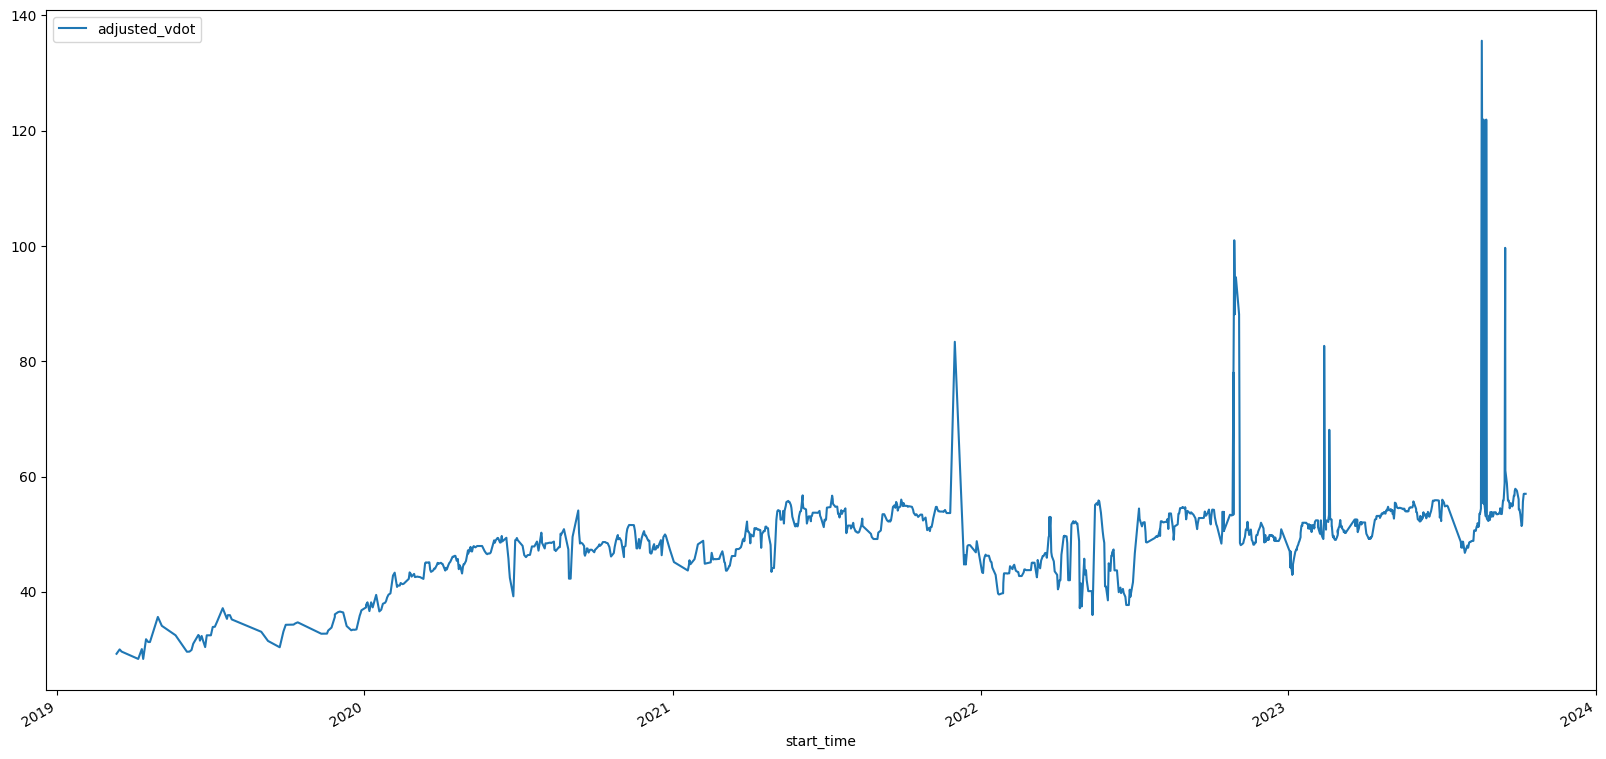

In [23]:
# plot adjusted_vdot over time
m = m.sort_index()
m.rolling('7D').median().plot(y='adjusted_vdot', figsize=(20, 10))

In [24]:
m.tail(10)['adjusted_vdot']

start_time
2023-10-05 19:22:35     57.143123
2023-10-06 09:12:38     57.732671
2023-10-07 08:33:29     56.987624
2023-10-07 14:17:12    147.709549
2023-10-08 08:01:44     55.000097
2023-10-08 08:58:12     53.467448
2023-10-08 09:40:15     59.364314
2023-10-08 10:38:09     52.330337
2023-10-08 12:32:22    152.301265
2023-10-09 14:36:38     59.436519
Name: adjusted_vdot, dtype: float64

/var/folders/8h/p7tllcw96sv_k_1rvz_4h51m0000gn/T/ipykernel_2092/623191192.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  m.groupby(pd.Grouper(freq='D')).sum()['distance'].plot()


<Axes: xlabel='start_time'>

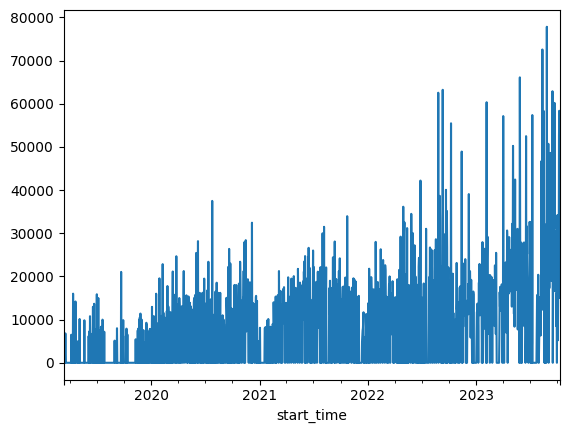

In [25]:
laps = pd.read_sql_table('laps', con=engine, index_col='id')
m = pd.merge(df, laps.groupby('activity_id').first().reset_index(), left_on='id', right_on='activity_id', how='outer')
m.set_index('start_time', inplace=True)
m.groupby(pd.Grouper(freq='D')).sum()['distance'].plot()

In [26]:
activity = 9584418189
records = pd.read_sql_table('records', con=engine, index_col='id')


<Axes: xlabel='timestamp'>

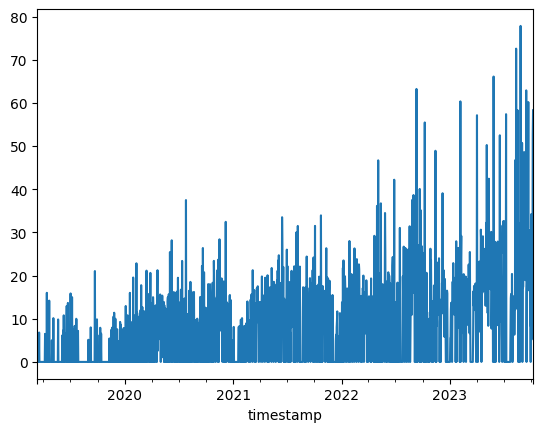

In [27]:
records = records.sort_index()
records['r_distance'] = records.groupby('activity_id')['distance'].diff() / 1000
r = records.set_index('timestamp')
r.groupby(pd.Grouper(freq='D')).sum()['r_distance'].plot()

In [28]:
def calculate_trimp(hr, t):
    # hr = (np.array(tcx.hr_values()) - FCR) / (FCM - FCR)
    # Fix missing values by interpolation
    hr = hr.interpolate()
    hr = (np.array(hr) - FCR) / (FCM - FCR)

    if len(hr) == 0:
        print('No HR data')
        return np.NaN
    else:
        t = np.diff(t) / 1000000000
        t = t.astype(float)
        # Trim elapsed seconds to 0.5min
        t = [min(elt / 60., 0.5) for elt in t]

        if len(hr) < len(t):
            t = t[:len(hr)]
        elif len(hr) > len(t):
            hr = hr[:len(t)]

        return np.sum(t * hr * 0.64*np.exp(1.92 * hr))

In [49]:
records.loc[records['activity_id'] == 12228509616].sort_values(by='timestamp').head(10)

,timestamp,position_lat,position_long,distance,altitude,enhanced_speed,enhanced_altitude,vertical_oscillation,stance_time_percent,stance_time,vertical_ratio,stance_time_balance,step_length,heart_rate,cadence,activity_id,r_distance
id,,,,,,,,,,,,,,,,,
3736201,2023-10-08 12:32:22,48.129278,-1.695970,2.98,NaN,2.781,47.4,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,12228509616,NaN
3736202,2023-10-08 12:32:23,48.129301,-1.695944,6.21,NaN,3.135,47.4,NaN,NaN,NaN,NaN,NaN,NaN,77.0,NaN,12228509616,0.00323
3736203,2023-10-08 12:32:24,48.129327,-1.695921,9.42,NaN,3.490,47.4,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,12228509616,0.00321
3736204,2023-10-08 12:32:25,48.129369,-1.695903,14.29,NaN,4.367,47.4,NaN,NaN,NaN,NaN,NaN,NaN,82.0,NaN,12228509616,0.00487
3736205,2023-10-08 12:32:26,48.129415,-1.695885,19.51,NaN,4.833,47.4,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN,12228509616,0.00522
3736206,2023-10-08 12:32:27,48.129462,-1.695863,24.95,NaN,5.057,47.6,NaN,NaN,NaN,NaN,NaN,NaN,93.0,NaN,12228509616,0.00544
3736207,2023-10-08 12:32:28,48.129513,-1.695839,30.91,NaN,5.402,47.8,NaN,NaN,NaN,NaN,NaN,NaN,96.0,NaN,12228509616,0.00596
3736208,2023-10-08 12:32:29,48.129563,-1.695815,36.80,NaN,5.701,47.8,NaN,NaN,NaN,NaN,NaN,NaN,96.0,NaN,12228509616,0.00589
3736209,2023-10-08 12:32:30,48.129615,-1.695795,42.73,NaN,5.794,48.0,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,12228509616,0.00593


In [29]:
activities = pd.read_sql_table('activities', con=engine)

def parse_record_for_date(record):
    try:
        return record['timestamp'].iloc[0]
    except Exception as e:
        print(e)
    return np.NaN

activities['trimp'] = activities.apply(lambda row: calculate_trimp(records.loc[records['activity_id'] == row['id']]['heart_rate'], records.loc[records['activity_id'] == row['id']]['timestamp']), axis=1)
activities['date'] = activities.apply(lambda row: parse_record_for_date(records.loc[records['activity_id'] == row['id']]), axis=1)

No HR data
No HR data
No HR data
No HR data
No HR data
No HR data
No HR data
No HR data
No HR data
No HR data
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


In [30]:
a = activities.set_index('date')
daily_trimp = a.groupby(pd.Grouper(freq='D')).sum()[['trimp']]

In [31]:
daily_trimp['atl'] = daily_trimp['trimp'].ewm(span=7, adjust=False).mean()
daily_trimp['ctl'] = daily_trimp['trimp'].ewm(span=42, adjust=False).mean()
daily_trimp['tsb'] = daily_trimp['ctl'] - daily_trimp['atl']

In [32]:
daily_trimp[['trimp', 'atl', 'ctl', 'tsb']]

,trimp,atl,ctl,tsb
date,,,,
2019-03-12,81.536238,81.536238,81.536238,0.000000
2019-03-13,0.000000,61.152179,77.743855,16.591676
2019-03-14,0.000000,45.864134,74.127862,28.263728
2019-03-15,0.000000,34.398101,70.680054,36.281954
2019-03-16,84.767060,46.990340,71.335264,24.344924
...,...,...,...,...
2023-10-05,170.659032,145.619003,147.630533,2.011530
2023-10-06,174.154241,152.752813,148.864194,-3.888619
2023-10-07,241.181589,174.860007,153.158026,-21.701980


In [33]:
max_atl = daily_trimp['atl'].max()
daily_trimp['atl_percentage'] = (daily_trimp['atl'] / max_atl) * 100
max_ctl = daily_trimp['ctl'].max()
daily_trimp['ctl_percentage'] = (daily_trimp['ctl'] / max_ctl) * 100

<Axes: xlabel='date'>

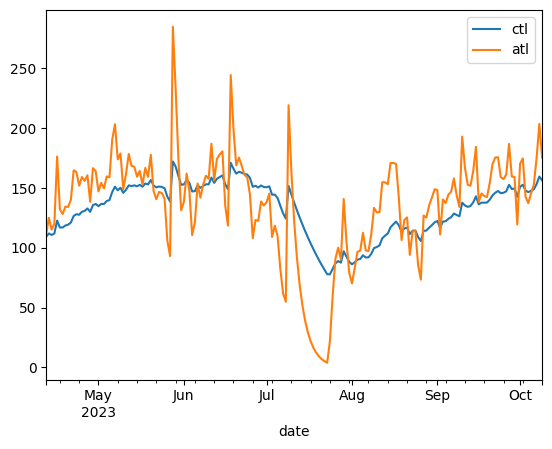

In [34]:
daily_trimp[['ctl', 'atl']].iloc[-181:].plot()

In [35]:
r1, r2, k1, k2 = 1.0, 2.0, 49, 11
fitness, fatigue = 0, 0
fitness_list, fatigue_list = [], []
trimp = daily_trimp['trimp'].iloc[-365:]
for elt in trimp:
    fitness = fitness * np.exp(-1/r1) + elt
    fitness_list.append(fitness)
    fatigue = fatigue * np.exp(-1/r2) + elt
    fatigue_list.append(fatigue)
    performance = fitness * k1 - fatigue * k2

In [36]:
performance, fatigue, fitness

(7055.019632626283, 444.4150671510288, 243.74664023035916)

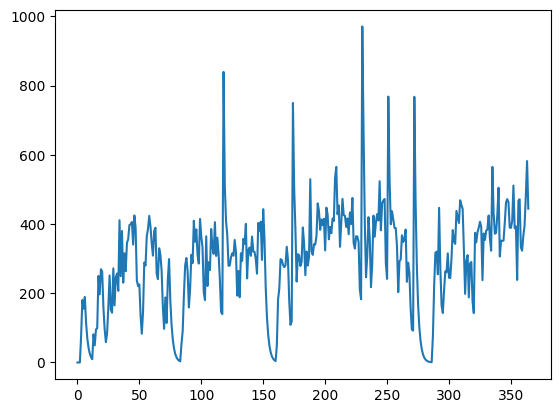

In [37]:
# plt.plot(fitness_list)
plt.plot(fatigue_list)

<Axes: xlabel='date'>

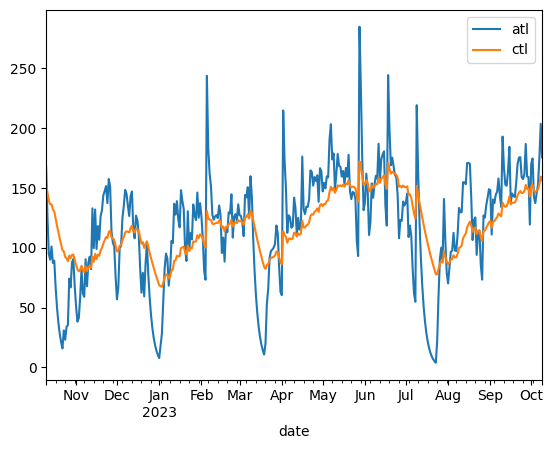

In [38]:
daily_trimp[['atl', 'ctl']].iloc[-365:].plot()

<Axes: xlabel='date'>

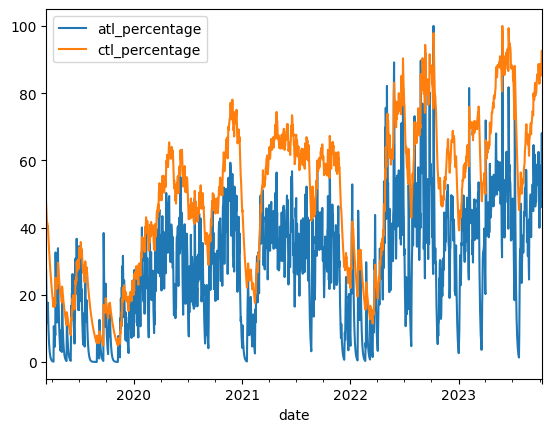

In [39]:
daily_trimp[['atl_percentage', 'ctl_percentage']].plot()

<Axes: xlabel='date'>

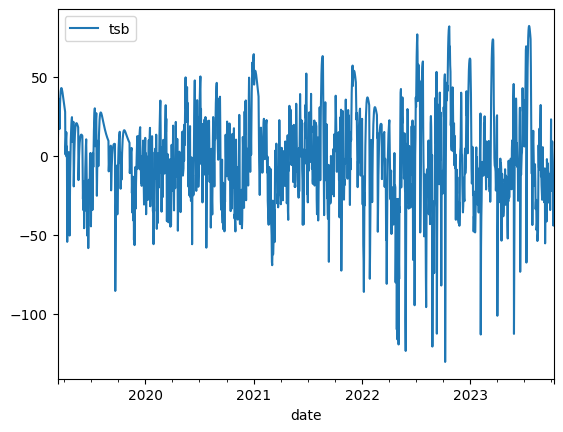

In [40]:
daily_trimp[['tsb',]].plot()

In [44]:
daily_trimp[['atl', 'ctl']].iloc[-7:].mean() / daily_trimp[['atl', 'ctl']].max()

atl    0.541153
ctl    0.879241
dtype: float64

In [45]:
0.879241 - 0.541153

0.33808800000000006

In [108]:
import fitdecode
import matplotlib.pyplot as plt
import numpy as np

In [155]:
import json
# with fitdecode.FitReader(f"../data/raw/{5548089624}/{5548089624}_ACTIVITY.fit") as fit_file:
with fitdecode.FitReader(f"../data/raw/{12260855622}/{12260855622}_ACTIVITY.fit") as fit_file:
    for frame in fit_file:
        if frame.frame_type == fitdecode.FIT_FRAME_DATA:
            print(f"New data frame {frame.name} with {len(frame.fields)} fields")
            # user_data = {}
            # for field in frame.fields:
            #     if 'unknown' not in field.name:
            #         value = field.value
            #         if isinstance(field.value, tuple):
            #             value = json.dumps(value)
            #         user_data[field.name] = value
            # if frame.name == 'activity':
            #     print(user_data)
            #     break

New data frame file_id with 7 fields
New data frame file_creator with 5 fields
New data frame unknown_288 with 4 fields
New data frame unknown_327 with 8 fields
New data frame unknown_326 with 3 fields
New data frame unknown_327 with 8 fields
New data frame unknown_326 with 3 fields
New data frame event with 7 fields
New data frame device_info with 28 fields
New data frame device_info with 28 fields
New data frame device_info with 28 fields
New data frame device_info with 28 fields
New data frame device_info with 28 fields
New data frame device_info with 28 fields
New data frame device_info with 28 fields
New data frame device_info with 28 fields
New data frame unknown_22 with 11 fields
New data frame unknown_141 with 5 fields
New data frame device_settings with 107 fields
New data frame user_profile with 36 fields
New data frame unknown_147 with 65 fields
New data frame unknown_147 with 65 fields
New data frame unknown_147 with 65 fields
New data frame unknown_147 with 65 fields
New d

In [50]:
from sqlalchemy import inspect
from stridze.db import engine

inspector = inspect(engine)

# Get the list of table names
table_names = inspector.get_table_names()

# Print the table names
for table_name in table_names:
    print(table_name)

strava
users
activities
gpx_points
laps
records
tcx_laps
track_points


In [64]:
from typing import Optional

from sqlmodel import Field, SQLModel, create_engine, Session
from datetime import time

class Activity(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    timestamp: Optional[datetime]
    total_timer_time: Optional[float]
    local_timestamp: Optional[datetime]
    num_sessions: Optional[int]
    type: Optional[str]
    event: Optional[str]
    event_type: Optional[str]
    event_group: Optional[str]

class DeviceInfo(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    timestamp: Optional[datetime]
    serial_number: Optional[str]
    cum_operating_time: Optional[float]
    manufacturer: Optional[str]
    garmin_product: Optional[int]
    software_version: Optional[float]
    battery_voltage: Optional[float]
    ant_device_number: Optional[int]
    device_index: Optional[int]
    device_type: Optional[int]
    hardware_version: Optional[str]
    battery_status: Optional[str]
    sensor_position: Optional[str]
    ant_transmission_type: Optional[str]
    ant_network: Optional[str]
    source_type: Optional[str]

class DeviceSettings(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    utc_offset: Optional[int]
    time_offset: Optional[int]
    auto_activity_detect: Optional[str]
    autosync_min_steps: Optional[int]
    autosync_min_time: Optional[int]
    active_time_zone: Optional[int]
    time_mode: Optional[str]
    time_zone_offset: Optional[float]
    backlight_mode: Optional[str]
    activity_tracker_enabled: Optional[bool]
    move_alert_enabled: Optional[bool]
    date_mode: Optional[str]
    display_orientation: Optional[str]
    mounting_side: Optional[str]
    lactate_threshold_autodetect_enabled: Optional[bool]
    number_of_screens: Optional[int]

class EventData(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    timestamp: Optional[datetime]
    data: Optional[int]
    event: Optional[int]
    event_type: Optional[str]
    event_group: Optional[int]

class FileCreator(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    software_version: Optional[int]
    hardware_version: Optional[int]

class FileId(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    serial_number: Optional[int]
    time_created: Optional[datetime]
    manufacturer: Optional[str]
    garmin_product: Optional[str]
    number: Optional[int]
    type: Optional[str]

class GPSMetadata(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    enhanced_altitude: Optional[float]
    enhanced_speed: Optional[float]

class HRV(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    time: Optional[int]

class Lap(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    timestamp: Optional[datetime]
    start_time: Optional[datetime]
    start_position_lat: Optional[int]
    start_position_long: Optional[int]
    end_position_lat: Optional[int]
    end_position_long: Optional[int]
    total_elapsed_time: Optional[float]
    total_timer_time: Optional[float]
    total_distance: Optional[float]
    total_strides: Optional[int]
    total_work: Optional[float]
    time_standing: Optional[float]
    avg_left_power_phase: Optional[str]
    avg_left_power_phase_peak: Optional[str]
    avg_right_power_phase: Optional[str]
    avg_right_power_phase_peak: Optional[str]
    avg_power_position: Optional[str]
    max_power_position: Optional[str]
    enhanced_avg_speed: Optional[float]
    enhanced_max_speed: Optional[float]
    enhanced_avg_altitude: Optional[float]
    enhanced_min_altitude: Optional[float]
    enhanced_max_altitude: Optional[float]
    total_grit: Optional[float]
    avg_flow: Optional[float]
    message_index: Optional[int]
    total_calories: Optional[int]
    total_fat_calories: Optional[float]
    avg_speed: Optional[float]
    max_speed: Optional[float]
    avg_power: Optional[float]
    max_power: Optional[float]
    total_ascent: Optional[int]
    total_descent: Optional[int]
    num_lengths: Optional[int]
    normalized_power: Optional[float]
    left_right_balance: Optional[float]
    first_length_index: Optional[int]
    avg_stroke_distance: Optional[float]
    num_active_lengths: Optional[int]
    wkt_step_index: Optional[int]
    avg_vertical_oscillation: Optional[float]
    avg_stance_time_percent: Optional[float]
    avg_stance_time: Optional[float]
    stand_count: Optional[int]
    avg_vertical_ratio: Optional[float]
    avg_stance_time_balance: Optional[float]
    avg_step_length: Optional[float]
    event: Optional[str]
    event_type: Optional[str]
    avg_heart_rate: Optional[int]
    max_heart_rate: Optional[int]
    avg_running_cadence: Optional[int]
    max_running_cadence: Optional[int]
    intensity: Optional[float]
    lap_trigger: Optional[str]
    sport: Optional[str]
    event_group: Optional[int]
    swim_stroke: Optional[str]
    sub_sport: Optional[str]
    avg_temperature: Optional[int]
    max_temperature: Optional[int]
    avg_fractional_cadence: Optional[float]
    max_fractional_cadence: Optional[float]
    total_fractional_cycles: Optional[float]
    avg_left_torque_effectiveness: Optional[float]
    avg_right_torque_effectiveness: Optional[float]
    avg_left_pedal_smoothness: Optional[float]
    avg_right_pedal_smoothness: Optional[float]
    avg_combined_pedal_smoothness: Optional[float]
    avg_left_pco: Optional[float]
    avg_right_pco: Optional[float]
    avg_cadence_position: Optional[str]
    max_cadence_position: Optional[str]
    total_fractional_ascent: Optional[float]
    total_fractional_descent: Optional[float]

class Record(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    timestamp: datetime
    position_lat: int
    position_long: int
    distance: float
    enhanced_speed: float
    enhanced_altitude: float
    vertical_oscillation: float
    stance_time_percent: float
    stance_time: float
    vertical_ratio: float
    stance_time_balance: float
    step_length: float
    heart_rate: int
    cadence: int
    temperature: int
    activity_type: str
    fractional_cadence: float

class Session(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    timestamp: Optional[datetime]
    start_time: Optional[datetime]
    start_position_lat: Optional[int]
    start_position_long: Optional[int]
    total_elapsed_time: Optional[float]
    total_timer_time: Optional[float]
    total_distance: Optional[float]
    total_strides: Optional[int]
    nec_lat: Optional[int]
    nec_long: Optional[int]
    swc_lat: Optional[int]
    swc_long: Optional[int]
    avg_stroke_count: Optional[float]
    total_work: Optional[float]
    time_standing: Optional[float]
    avg_left_power_phase: Optional[str]
    avg_left_power_phase_peak: Optional[str]
    avg_right_power_phase: Optional[str]
    avg_right_power_phase_peak: Optional[str]
    avg_power_position: Optional[str]
    max_power_position: Optional[str]
    enhanced_avg_speed: Optional[float]
    enhanced_max_speed: Optional[float]
    total_grit: Optional[float]
    avg_flow: Optional[float]
    message_index: Optional[int]
    total_calories: Optional[int]
    avg_speed: Optional[float]
    max_speed: Optional[float]
    avg_power: Optional[float]
    max_power: Optional[float]
    total_ascent: Optional[int]
    total_descent: Optional[int]
    first_lap_index: Optional[int]
    num_laps: Optional[int]
    num_lengths: Optional[int]
    normalized_power: Optional[float]
    training_stress_score: Optional[float]
    intensity_factor: Optional[float]
    left_right_balance: Optional[float]
    avg_stroke_distance: Optional[float]
    pool_length: Optional[float]
    threshold_power: Optional[float]
    num_active_lengths: Optional[int]
    avg_vertical_oscillation: Optional[float]
    avg_stance_time_percent: Optional[float]
    avg_stance_time: Optional[float]
    stand_count: Optional[float]
    avg_vertical_ratio: Optional[float]
    avg_stance_time_balance: Optional[float]
    avg_step_length: Optional[float]
    event: Optional[str]
    event_type: Optional[str]
    sport: Optional[str]
    sub_sport: Optional[str]
    avg_heart_rate: Optional[int]
    max_heart_rate: Optional[int]
    avg_running_cadence: Optional[int]
    max_running_cadence: Optional[int]
    total_training_effect: Optional[float]
    event_group: Optional[int]
    trigger: Optional[str]
    swim_stroke: Optional[str]
    pool_length_unit: Optional[str]
    avg_temperature: Optional[int]
    max_temperature: Optional[int]
    avg_fractional_cadence: Optional[float]
    max_fractional_cadence: Optional[float]
    total_fractional_cycles: Optional[float]
    avg_left_torque_effectiveness: Optional[float]
    avg_right_torque_effectiveness: Optional[float]
    avg_left_pedal_smoothness: Optional[float]
    avg_right_pedal_smoothness: Optional[float]
    avg_combined_pedal_smoothness: Optional[float]
    avg_left_pco: Optional[float]
    avg_right_pco: Optional[float]
    avg_cadence_position: Optional[str]
    max_cadence_position: Optional[str]
    total_anaerobic_training_effect: Optional[float]
    total_fractional_ascent: Optional[float]
    total_fractional_descent: Optional[float]

class Sport(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    name: Optional[str]
    sport: Optional[str]
    sub_sport: Optional[str]

class ZonesTarget(SQLModel):
    id: int = Field(default=None, primary_key=True, index=True)
    functional_threshold_power: Optional[int]
    max_heart_rate: Optional[int]
    threshold_heart_rate: Optional[int]
    hr_calc_type: Optional[int]
    pwr_calc_type: Optional[str]

class UserProfile(SQLModel, table=True):
    id: int = Field(default=None, primary_key=True, index=True)
    wake_time: Optional[time]
    sleep_time: Optional[time]
    weight: Optional[float]
    user_running_step_length: Optional[float]
    user_walking_step_length: Optional[float]
    gender: Optional[str]
    height: Optional[float]
    language: Optional[str]
    elev_setting: Optional[str]
    weight_setting: Optional[str]
    resting_heart_rate: Optional[int]
    hr_setting: Optional[str]
    speed_setting: Optional[str]
    dist_setting: Optional[str]
    activity_class: Optional[int]
    position_setting: Optional[str]
    temperature_setting: Optional[str]
    height_setting: Optional[str]
    depth_setting: Optional[str]

/Users/julienroulle/dev/stridze-tools/.venv/lib/python3.11/site-packages/sqlmodel/main.py:369: SAWarning: This declarative base already contains a class with the same class name and module name as __main__.UserData, and will be replaced in the string-lookup table.
  DeclarativeMeta.__init__(cls, classname, bases, dict_used, **kw)


InvalidRequestError: Table 'userdata' is already defined for this MetaData instance.  Specify 'extend_existing=True' to redefine options and columns on an existing Table object.

In [65]:
from stridze.db import engine, get_session
SQLModel.metadata.create_all(engine)

In [73]:
session = get_session()

# Create an instance of the UserData class
user_data = UserData(**user_data)

session.add(user_data)
session.commit()

In [74]:
from sqlmodel import select
statement = select(UserData)

In [134]:
import struct

In [137]:
struct.pack('i', 2909)

b']\x0b\x00\x00'

In [138]:
0x2909  

10505

In [143]:
int("0x2909")

ValueError: invalid literal for int() with base 10: '0x2909'

In [144]:
import stravalib

In [145]:
client = stravalib.Client(access_token="810c0bcf1054ccd190117cc9a62a138797dcd3c8")

In [147]:
activities = client.get_activities()

In [151]:
activity = activities.next()


In [153]:
activity.to_dict()

{'id': 7379159766,
 'guid': None,
 'external_id': 'garmin_push_9098707506',
 'upload_id': 7863164616,
 'athlete': {'firstname': None,
  'lastname': None,
  'profile_medium': None,
  'profile': None,
  'city': None,
  'state': None,
  'country': None,
  'sex': None,
  'friend': None,
  'follower': None,
  'premium': None,
  'summit': None,
  'created_at': None,
  'updated_at': None,
  'approve_followers': None,
  'badge_type_id': None,
  'follower_count': None,
  'friend_count': None,
  'mutual_friend_count': None,
  'athlete_type': None,
  'date_preference': None,
  'measurement_preference': None,
  'email': None,
  'clubs': None,
  'bikes': None,
  'shoes': None,
  'super_user': None,
  'email_language': None,
  'weight': None,
  'max_heartrate': None,
  'username': None,
  'description': None,
  'instagram_username': None,
  'offer_in_app_payment': None,
  'global_privacy': None,
  'receive_newsletter': None,
  'email_kom_lost': None,
  'dateofbirth': None,
  'facebook_sharing_enable

In [49]:
pd.read_sql_table('userdata', con=engine)

ValueError: Table userdata not found

In [48]:
# delete table userdata
from sqlalchemy import MetaData
metadata = MetaData()
metadata.reflect(engine)
for table in reversed(metadata.sorted_tables):
    if table.name == 'userdata':
        table.drop(engine)

# commit changes
from stridze.db import get_session
session = get_session()
session.commit()

In [60]:
from stridze.db import engine, get_session
session = get_session()

from stridze.db.models import Activity, User

In [63]:
user = session.query(User).first()
